In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
import pyproj
from pyproj import Proj, transform
import numpy as np
import math
import gdown
%matplotlib inline

The shape file: https://drive.google.com/drive/folders/1A6FuXF5VW_Lek5usGw672ZA3aBlZX90b?usp=drive_link


In [ ]:
finland = gpd.read_file("../../data/shapefiles/mb800bj2863.shp")

In [ ]:
df = pd.read_csv("../../data/samples/tree_data_sample.csv")
df

,date,lat,lon,municipality,taxonId,scientificName,verbatim
0,2023-09-17,61.455708,23.839126,Tampere,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris
1,2023-09-17,60.222124,24.809073,Espoo,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris
2,2023-09-17,61.453762,23.828064,Tampere,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris
3,2023-09-17,60.221603,24.818331,Espoo,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris
4,2023-09-16,61.433409,23.794277,Tampere,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris
...,...,...,...,...,...,...,...
115752,NaN,60.879859,22.271316,Pöytyä,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris
115753,NaN,60.920732,22.412991,Pöytyä,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris
115754,NaN,66.403813,29.151553,Kuusamo,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris
115755,NaN,60.858113,22.421991,Pöytyä,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris


In [ ]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
geo_df = gpd.GeoDataFrame(df, crs=finland.crs, geometry=geometry)
geo_df

,date,lat,lon,municipality,taxonId,scientificName,verbatim,geometry
0,2023-09-17,61.455708,23.839126,Tampere,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris,POINT (23.83913 61.45571)
1,2023-09-17,60.222124,24.809073,Espoo,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris,POINT (24.80907 60.22212)
2,2023-09-17,61.453762,23.828064,Tampere,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris,POINT (23.82806 61.45376)
3,2023-09-17,60.221603,24.818331,Espoo,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris,POINT (24.81833 60.22160)
4,2023-09-16,61.433409,23.794277,Tampere,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris,POINT (23.79428 61.43341)
...,...,...,...,...,...,...,...,...
115752,NaN,60.879859,22.271316,Pöytyä,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris,POINT (22.27132 60.87986)
115753,NaN,60.920732,22.412991,Pöytyä,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris,POINT (22.41299 60.92073)
115754,NaN,66.403813,29.151553,Kuusamo,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris,POINT (29.15155 66.40381)
115755,NaN,60.858113,22.421991,Pöytyä,http://tun.fi/MX.37819,Pinus sylvestris,Pinus sylvestris,POINT (22.42199 60.85811)


In [ ]:
finland = finland.to_crs({"init":"epsg:3050"})
geo_df = geo_df.to_crs({"init":"epsg:3050"})


In [ ]:
geo_df.dropna(subset=["scientificName", "lat", "lon"], inplace=True)

In [ ]:
# total area for the grid
xmin, ymin, xmax, ymax= finland.total_bounds
# how many cells across and down
cell_size = 10000
# projection of the grid
crs = {"init":"epsg:3035"}
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(box(x0, y0, x1, y1))
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                 crs=crs)

<Axes: >

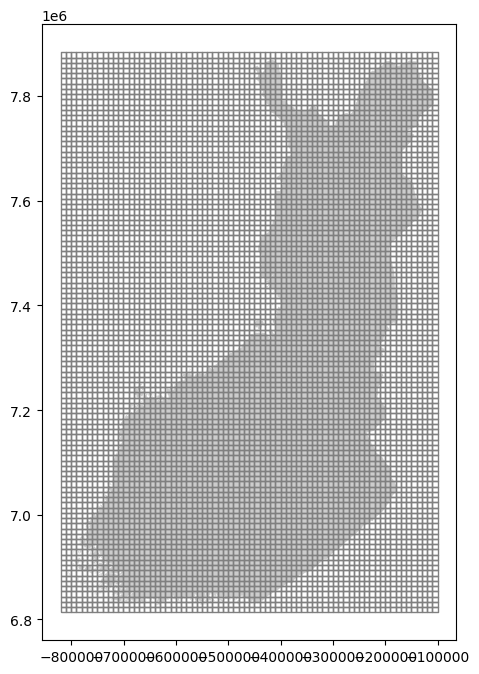

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
finland.plot(ax=ax, alpha=0.4, color='grey')
cell.plot(ax=ax, facecolor="none", edgecolor='grey')

In [ ]:
merged = gpd.sjoin(geo_df, cell, how='left', op='within')
merged

In [ ]:
dissolved = merged.dissolve(by="index_right", aggfunc={"scientificName":lambda x: x.unique()})
cell.loc[dissolved.index, 'speciesRichness'] = dissolved.scientificName.values
cell.loc[dissolved.index, 'count'] = np.vectorize(len)(dissolved.scientificName.values)

(-856359.2473006651, -64359.24730066513, 6760750.719854616, 7926750.719854616)

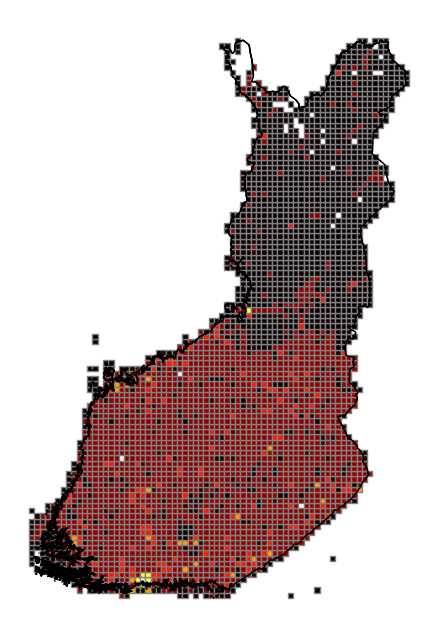

In [ ]:
ax = cell.plot(column='count', figsize=(12, 8), cmap='hot', vmax=cell["count"].max(), edgecolor="grey")
plt.autoscale(False)
finland.plot(ax=ax, color='none', edgecolor='black')
ax.axis('off')

In [ ]:
len(np.arange(xmin, xmax+cell_size, cell_size))

72

In [ ]:
len(np.arange(ymin, ymax+cell_size, cell_size))

107

In [ ]:
neighbor_weight = 0.5

In [ ]:
cell_notna = cell[~cell.speciesRichness.isna()]

In [ ]:
def get_neighbors(i):
    neighbors = [i - 1, i + 1, i - 107, i + 107, i - 107 - 1, i - 107 + 1, i + 107 - 1, i + 107 + 1]
    neighbors = [n for n in neighbors if n >= 0 and n < 7704]
    return neighbors

In [ ]:
cell["neighbors"] = cell.index.to_series().apply(get_neighbors)

In [ ]:
cell

,geometry,speciesRichness,count,neighbors
0,"POLYGON ((-820359.247 6813750.720, -820359.247...",NaN,NaN,"[1, 107, 106, 108]"
1,"POLYGON ((-820359.247 6823750.720, -820359.247...",NaN,NaN,"[0, 2, 108, 107, 109]"
2,"POLYGON ((-820359.247 6833750.720, -820359.247...",NaN,NaN,"[1, 3, 109, 108, 110]"
3,"POLYGON ((-820359.247 6843750.720, -820359.247...",NaN,NaN,"[2, 4, 110, 109, 111]"
4,"POLYGON ((-820359.247 6853750.720, -820359.247...",NaN,NaN,"[3, 5, 111, 110, 112]"
...,...,...,...,...
7699,"POLYGON ((-110359.247 7833750.720, -110359.247...",NaN,NaN,"[7698, 7700, 7592, 7591, 7593]"
7700,"POLYGON ((-110359.247 7843750.720, -110359.247...",NaN,NaN,"[7699, 7701, 7593, 7592, 7594]"
7701,"POLYGON ((-110359.247 7853750.720, -110359.247...",NaN,NaN,"[7700, 7702, 7594, 7593, 7595]"
7702,"POLYGON ((-110359.247 7863750.720, -110359.247...",NaN,NaN,"[7701, 7703, 7595, 7594, 7596]"


In [ ]:
def smooth(row):
    try:
        neighbors = row["neighbors"]
        all_neighbor_species = np.concatenate(cell.loc[neighbors, "speciesRichness"].reset_index(drop=True))
        all_species = np.concatenate([all_neighbor_species, row["speciesRichness"]])
        return len(np.unique(all_species))
    except:
        return row["count"]

In [ ]:
cell["smoothSpeciesRichness"] = cell.apply(smooth, axis=1)

In [ ]:
for i in range(7704):
    neighbors = cell.loc[i, "neighbor"]
    count = 0
    s = 0
    for n in neighbors:
        r = cell.loc[n, "speciesRichness"]
        if not math.isnan(r) and r != 0:
            count += 1
            s += r
    non_smooth = cell.loc[i, "speciesRichness"]
    if not math.isnan(non_smooth) and non_smooth != 0 and count != 0:
        cell.loc[i, "smoothSpeciesRichness"] = round(s*neighbor_weight/count + non_smooth*(1 - neighbor_weight))

(-856359.2473006651, -64359.24730066513, 6760750.719854616, 7926750.719854616)

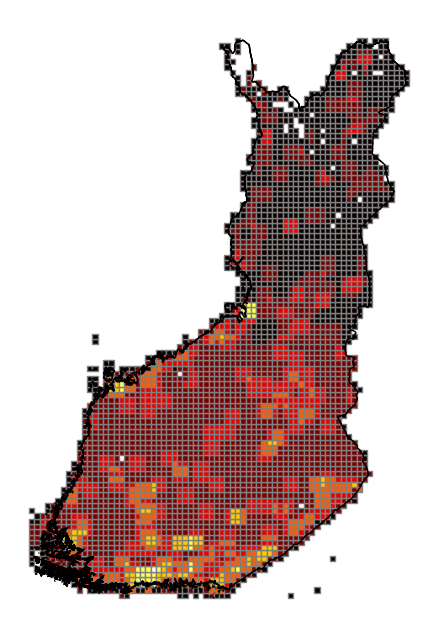

In [ ]:
ax = cell.plot(column='smoothSpeciesRichness', figsize=(12, 8), cmap='hot', vmax=cell["smoothSpeciesRichness"].max(), edgecolor="grey")
plt.autoscale(False)
finland.plot(ax=ax, color='none', edgecolor='black')
ax.axis('off')